# vLife Virtusa
## Human Protein Image Classification

### Usecase Description
Human protein images are classified as different human organelle labels viz nucleoli, rods, lipids, centrosome etc using keras algorithm. Each image is  taken in 4 different color filters, green being used as a filter and other 3 as reference filters.

You are predicting protein organelle localization labels for each sample. There are in total 28 different labels present in the dataset. The dataset is acquired in a highly standardized way using one imaging modality (confocal microscopy). However, the dataset comprises 27 different cell types of highly different morphology, which affect the protein patterns of the different organelles. All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references.

The labels are represented as integers that map to the following:

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

Data for this usecase can be found [here](https://www.kaggle.com/c/human-protein-atlas-image-classification/data)

### Dataset Description
* File descriptions
  - train.csv - filenames and labels for the training set.
  - sample_submission.csv - filenames for the test set, and a guide to constructing a working submission.
  - train.zip - All images for the training set.
  - test.zip - All images for the test set.
* Data fields
 - Id - the base filename of the sample. As noted above all samples consist of four files - blue, green, red, and yellow.
 - Target - in the training data, this represents the labels assigned to each sample.

### Import Section

In [21]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score as off1
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [22]:
BATCH_SIZE = 128
SEED = 777
SHAPE = (192, 192, 4)
DIR = '../input'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.05 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

ia.seed(SEED)

### Data Extraction
#### Extract train & test data from Respective directory

In [23]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)


### Intializing Data Generator Class
#### Data Preprocessing and Augmentation

In [24]:
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

## Predictive Models
### Keras Multi Processing

In [26]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

### Define Model Architecture

In [27]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(8, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    c1 = Conv2D(16, (3, 3), padding='same')(x)
    c1 = ReLU()(c1)
    c2 = Conv2D(16, (5, 5), padding='same')(x)
    c2 = ReLU()(c2)
    c3 = Conv2D(16, (7, 7), padding='same')(x)
    c3 = ReLU()(c3)
    c4 = Conv2D(16, (1, 1), padding='same')(x)
    c4 = ReLU()(c4)
    x = Concatenate()([c1, c2, c3, c4])
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropRate)(x)
    #x = Conv2D(256, (1, 1), activation='relu')(x)
    #x = BatchNormalization(axis=-1)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(28)(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.1)(x)
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [28]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 192, 192, 4)  16          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 190, 190, 8)  296         batch_normalization_10[0][0]     
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 190, 190, 8)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
batch_norm

### Model Training with Keras Data Generator

In [29]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=True, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=True, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [30]:
epochs = 10

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/10
219/219 [==============================] - 755s 3s/step - loss: 0.5494 - acc: 0.7557 - f1: 0.0991 - val_loss: 0.2621 - val_acc: 0.9399 - val_f1: 0.0999

Epoch 00001: val_loss improved from inf to 0.26210, saving model to ./base.model
Epoch 2/10
219/219 [==============================] - 100s 455ms/step - loss: 0.1989 - acc: 0.9447 - f1: 0.1051 - val_loss: 0.1803 - val_acc: 0.9402 - val_f1: 0.1146

Epoch 00002: val_loss improved from 0.26210 to 0.18031, saving model to ./base.model
Epoch 3/10
219/219 [==============================] - 98s 446ms/step - loss: 0.1641 - acc: 0.9482 - f1: 0.1178 - val_loss: 0.1679 - val_acc: 0.9417 - val_f1: 0.1118

Epoch 00003: val_loss improved from 0.18031 to 0.16794, saving model to ./base.model
Epoch 4/10
219/219 [==============================] - 95s 434ms/step - loss: 0.1579 - acc: 0.9489 - f1: 0.1242 - val_loss: 0.1710 - val_acc: 0.9414 - val_f1: 0.1125

Epoch 00004: val_loss did not improve from 0.16794
Epoch 5/10
219/219 [===============

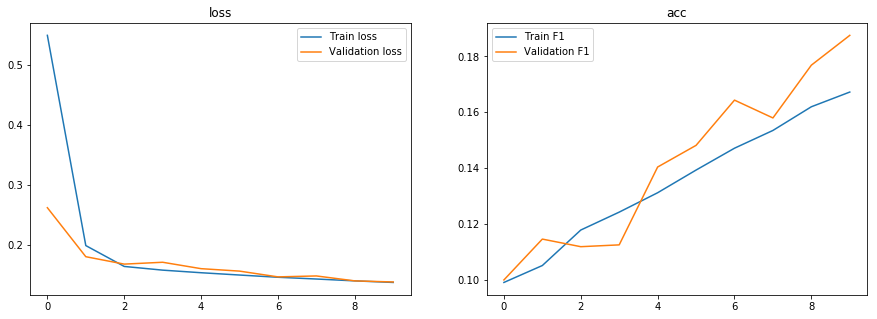

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

### Model validation
##### Perform validation on full validation dataset. Choose appropriate prediction threshold maximalizing the validation F1-score.

In [32]:
bestModel = load_model('./base.model', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})

In [33]:
fullValGen = vg

In [34]:
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(fullValGen))): 
    im, lbl = fullValGen[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

100%|██████████| 25/25 [00:08<00:00,  2.97it/s]

(3108, 28) (3108, 28)


In [35]:
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
  0%|          | 4/1000 [00:00<00:31, 32.08it/s]/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:28<00:00, 35.14it/s]


In [36]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))

Individual F1-scores for each class:
[0.78535535 0.23978202 0.50226929 0.30153846 0.54631829 0.31969309
 0.33333333 0.44023324 0.03680982 0.01754386 0.0212766  0.1994302
 0.28474576 0.22429907 0.44628099 0.00128617 0.04236669 0.05315615
 0.13479053 0.20689655 0.04166667 0.58971429 0.3190184  0.56838906
 0.32653061 0.60777724 0.04123711 0.        ]
Macro F1-score CV = 0.27256210126382857


Probability threshold maximizing CV F1-score for each class:
[0.303 0.091 0.182 0.145 0.582 0.14  0.243 0.122 0.004 0.005 0.004 0.085
 0.071 0.095 0.157 0.    0.015 0.013 0.041 0.082 0.018 0.305 0.104 0.22
 0.055 0.347 0.012 0.   ]


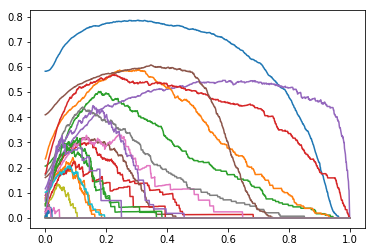

In [37]:
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [38]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 92/92 [04:28<00:00,  2.57s/it]


In [39]:
PP = np.array(P)

In [40]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('4channels_cnn_from_scratch.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 40382.64it/s]


## END